In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import seaborn as sns
import networkx as nx
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test, pairwise_logrank_test
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr

from utils import PROJECT_ROOT
from utils import reverse_dict
from definitions import (
    get_node_id,
    get_node_color,
    Protein_list_Danenberg,
    Protein_list_Jackson,
    Protein_list_display_Danenberg,
    Protein_list_display_Jackson,
    Cell_types_displayed_Danenberg,
    patient_ids_inner_validation,
    patient_ids_discovery,
    color_palette_Bigraph,
    color_palette_clinical,
)
sys.path.append("./..")
from cell_graph import Cell_Graph
from bi_graph import BiGraph
from population_graph import Population_Graph
from explainer import Explainer

# 0.Data Exploration

## Danenberg et al

### Load Data

In [2]:
cells_Danenberg = pd.read_csv('Datasets/Danenberg_et_al/cells.csv') 
clinical_Danenberg = pd.read_csv('Datasets/Danenberg_et_al/clinical.csv')
print("Initially,")
print(
    "{} patients ({} images) with cell data, {} patients with clinical data, ".format(
        len(cells_Danenberg["metabric_id"].unique()),
        len(cells_Danenberg["ImageNumber"].unique()),
        len(clinical_Danenberg["metabric_id"].unique()),
    )
)

Initially,
718 patients (794 images) with cell data, 2604 patients with clinical data, 


### Data Inclusion

#### Exclude samples with only normal tissues and in-situ carcinoma

In [3]:
print("\nRemove images without invasive tumor,")
cells_Danenberg = cells_Danenberg.loc[cells_Danenberg.isTumour == 1]
print(
    "{} patients ({} images) with cell data, {} patients with clinical data, ".format(
        len(cells_Danenberg["metabric_id"].unique()),
        len(cells_Danenberg["ImageNumber"].unique()),
        len(clinical_Danenberg["metabric_id"].unique()),
    )
)


Remove images without invasive tumor,
693 patients (749 images) with cell data, 2604 patients with clinical data, 


#### Exclude patients with clinical information missing

In [4]:
print("\nRemove patients with no clinical data,")
cells_Danenberg = cells_Danenberg.loc[cells_Danenberg["metabric_id"].isin(cells_Danenberg["metabric_id"])]
print(
    "{} patients ({} images) with cell data and clinical data, ".format(
        len(cells_Danenberg["metabric_id"].unique()),
        len(cells_Danenberg["ImageNumber"].unique()),
    )
)


Remove patients with no clinical data,
693 patients (749 images) with cell data and clinical data, 


#### Exclude images with less than 500 cells

In [5]:
# remove images with less than 500 cells
print("\nRemove images with less than 500 cells")
cells_per_image = cells_Danenberg.groupby("ImageNumber").size()
cells_Danenberg = cells_Danenberg.loc[
    cells_Danenberg["ImageNumber"].isin(cells_per_image[cells_per_image > 500].index)
]
clinical_Danenberg = clinical_Danenberg.loc[clinical_Danenberg["metabric_id"].isin(cells_Danenberg["metabric_id"].unique())]
print(
    "{} patients ({} images) with more than 500 cells and clinical data, ".format(
        len(cells_Danenberg["metabric_id"].unique()),
        len(cells_Danenberg["ImageNumber"].unique()),
    )
)


Remove images with less than 500 cells
589 patients (633 images) with more than 500 cells and clinical data, 


### Discovery and inner-validation sets partition

In [6]:
patient_ids_Danenberg = set(clinical_Danenberg["metabric_id"].unique())
# check discovery set and inner validation set are disjoint
assert set(patient_ids_discovery).isdisjoint(set(patient_ids_inner_validation))
# check discovery set and inner validation set are exhaustive
assert (
    set(patient_ids_discovery).union(set(patient_ids_inner_validation))
    == patient_ids_Danenberg
)

cells_discovery = pd.concat(
    [
        cells_Danenberg.loc[cells_Danenberg["metabric_id"] == i]
        for i in patient_ids_discovery
    ]
)
cells_inner_validation = pd.concat(
    [
        cells_Danenberg.loc[cells_Danenberg["metabric_id"] == i]
        for i in patient_ids_inner_validation
    ]
)
print("\nAfter splitting into discovery and validation sets,")
print(
    "{} patients and {} images in the discovery set".format(
        len(patient_ids_discovery),
        len(cells_discovery["ImageNumber"].unique()),
    )
)
print(
    "{} patients and {} images in the validation set".format(
        len(patient_ids_inner_validation),
        len(cells_inner_validation["ImageNumber"].unique()),
    )
)


After splitting into discovery and validation sets,
379 patients and 404 images in the discovery set
200 patients and 217 images in the validation set


### Fig.3.a. Data partition for Danenberg et al

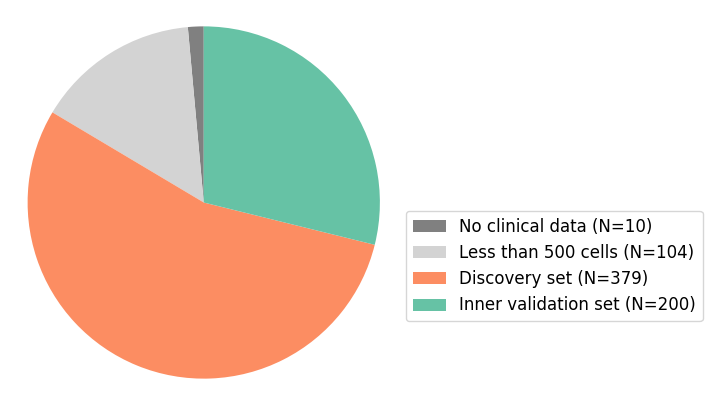

In [7]:
f, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(aspect="equal"))
labels = ['No clinical data (N=10)', 'Less than 500 cells (N=104)', 'Discovery set (N=379)', "Inner validation set (N=200)"]
sizes = [10, 104, 379, 200]
colors = ['grey','lightgrey',sns.color_palette("Set2")[1],sns.color_palette("Set2")[0]]
pie = ax.pie(sizes, labels=None,  startangle=90, colors=colors,wedgeprops=dict( linewidth=1))
ax.legend(labels, loc="upper left", bbox_to_anchor=(1, 0.5), fontsize = 12, )
# Equal aspect ratio ensures that the pie chart is circular.
plt.axis('equal')
# Show the plot
plt.show()


### Fig.A.1. Median protein profiling for Danenberg et al

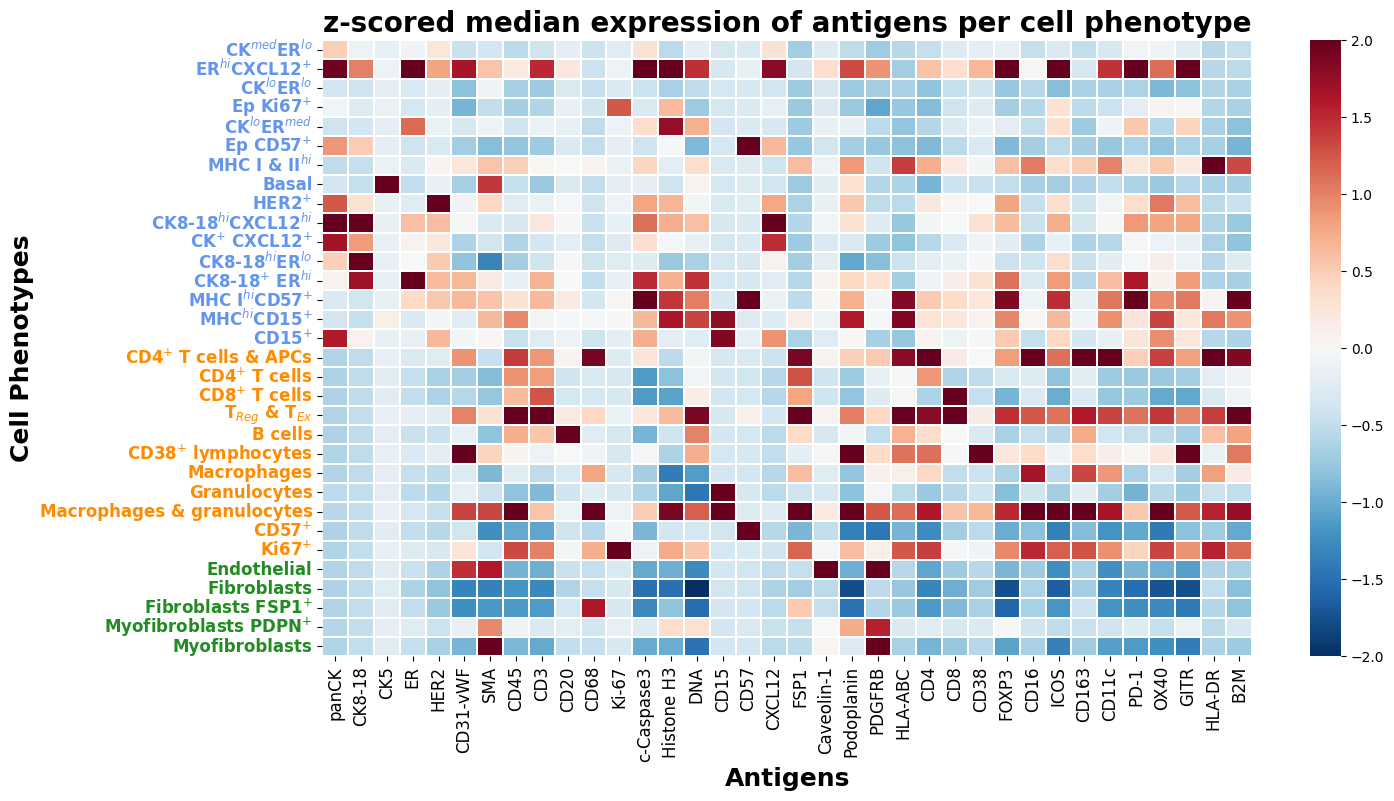

In [8]:
Cell_type_name_list = [
    reverse_dict(get_node_id("Danenberg", "CellType"))[i] for i in range(32)
]


custom_order = Cell_type_name_list
cells_Danenberg["meta_description"] = pd.Categorical(
    cells_Danenberg["meta_description"], categories=custom_order, ordered=True
)
expression_per_phenoptype = cells_Danenberg.groupby("meta_description")[Protein_list_Danenberg].median()
expression_per_phenoptype_scaled = (
    expression_per_phenoptype - expression_per_phenoptype.mean()
) / expression_per_phenoptype.std()


f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(
    expression_per_phenoptype_scaled,
    ax=ax,
    cmap="RdBu_r",
    center=0,
    vmin=-2,
    vmax=2,
    cbar=True,
    linewidth=0.1,
)
ax.set_xticklabels(
    Protein_list_display_Danenberg,
    fontsize=12,
)

ax.set_yticklabels(Cell_types_displayed_Danenberg, fontsize=12, fontweight="bold")
# ax.set_yticklabels(ax.get_yticklabels(), fontsize = 12, fontweight='bold')
ax.set_xlabel("Antigens", fontsize=18, fontweight="bold")
ax.set_ylabel("Cell Phenotypes", fontsize=18, fontweight="bold")
ytickcolors = ["cornflowerblue"] * 16 + ["darkorange"] * 11 + ["forestgreen"] * 5
for ytick, color in zip(ax.get_yticklabels(), ytickcolors):
    ytick.set_color(color)
ax.set_title(
    "z-scored median expression of antigens per cell phenotype",
    fontsize=20,
    fontweight="bold",
)
f.show()

## Jackson et el

### Load Data

In [9]:
cells_Jackson = pd.read_csv('Datasets/Jackson_et_al/cells.csv') 
clinical_Jackson = pd.read_csv('Datasets/Jackson_et_al/clinical.csv')
print("{} patients, {} images, and {} cells".format(
    len(clinical_Jackson['PID'].unique()), len(clinical_Jackson['core'].unique()), len(cells_Jackson)
)
)

285 patients, 376 images, and 855668 cells


### Data Inclusion

#### Exclude normal breast tissues

In [10]:
clinical_Jackson = clinical_Jackson[clinical_Jackson['diseasestatus'] == 'tumor']
print("{} patients, {} images, and {} cells".format(
    len(clinical_Jackson['PID'].unique()), len(clinical_Jackson['core'].unique()), len(cells_Jackson)
)
)


281 patients, 289 images, and 855668 cells


#### Exclude images with less than 500 cells

In [11]:
cells_per_image = cells_Jackson.groupby('core').size()
cells_Jackson = cells_Jackson.loc[cells_Jackson['core'].isin(cells_per_image[cells_per_image > 500].index)]
cells_Jackson = pd.merge(cells_Jackson, clinical_Jackson, on = 'core', how = 'inner')
print("{} patients, {} images, and {} cells".format(
    len(cells_Jackson['PID'].unique()), len(cells_Jackson['core'].unique()), len(cells_Jackson)
)
)


266 patients, 270 images, and 762616 cells


### Fig 3.b Data partition for Jackson et al

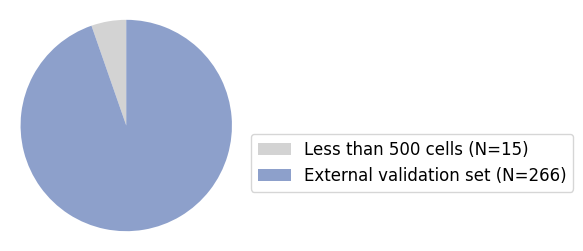

In [12]:
f, ax = plt.subplots(figsize=(3,3), subplot_kw=dict(aspect="equal"))
labels = ['Less than 500 cells (N=15)',  "External validation set (N=266)"]
sizes = [15, 266]
colors = ['lightgrey',sns.color_palette("Set2")[2]]
pie = ax.pie(sizes, labels=None,  startangle=90, colors=colors,wedgeprops=dict( linewidth=1))
ax.legend(labels, loc="upper left", bbox_to_anchor=(1, 0.5), fontsize = 12, )

# Equal aspect ratio ensures that the pie chart is circular.
plt.axis('equal')
# Show the plot
plt.show()

### Fig A.2 Median Protein profiling for Jackson et al

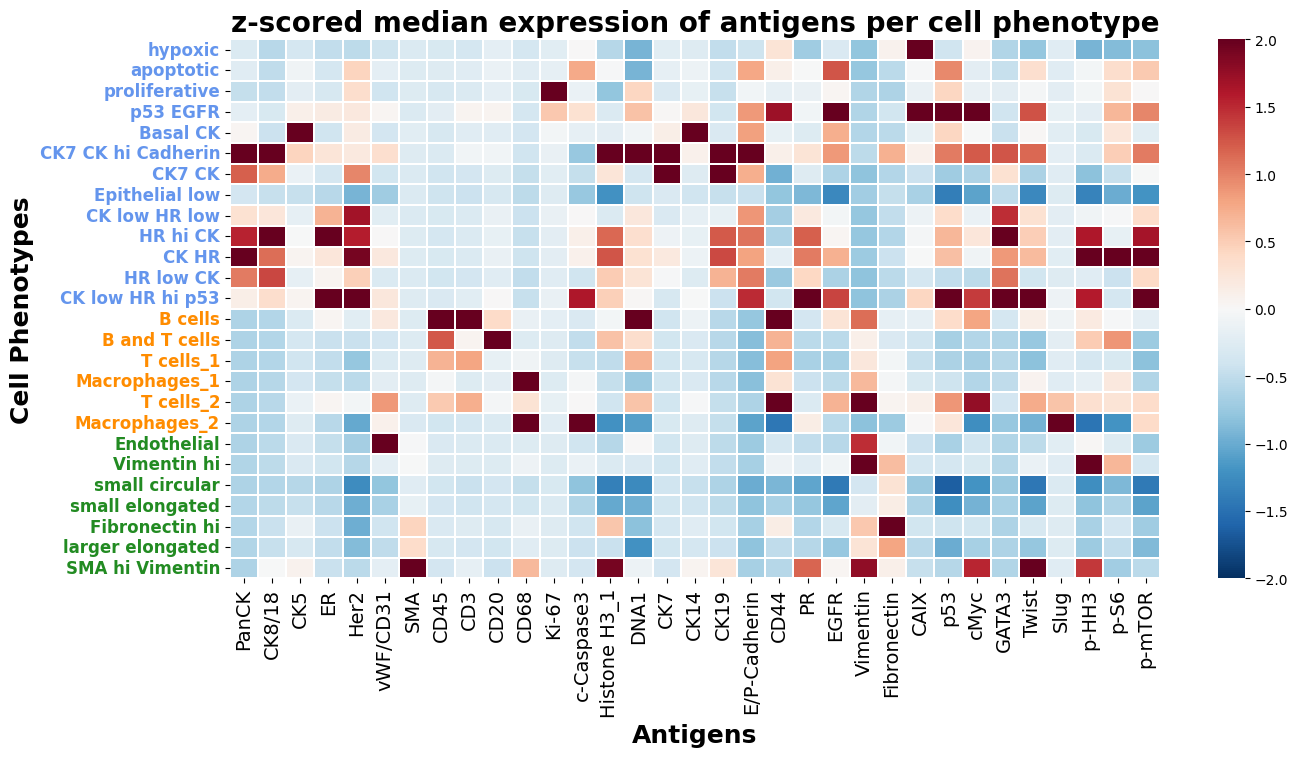

In [13]:
custom_order = [
    "hypoxic",
    "apoptotic",
    "proliferative",
    "p53 EGFR",
    "Basal CK",
    "CK7 CK hi Cadherin",
    "CK7 CK",
    "Epithelial low",
    "CK low HR low",
    "HR hi CK",
    "CK HR",
    "HR low CK",
    "CK low HR hi p53",
    "B cells",
    "B and T cells",
    "T cells_1",
    "Macrophages_1",
    "T cells_2",
    "Macrophages_2",
    "Endothelial",
    "Vimentin hi",
    "small circular",
    "small elongated",
    "Fibronectin hi",
    "larger elongated",
    "SMA hi Vimentin",
]
cells_Jackson["cell_type"] = pd.Categorical(
    cells_Jackson["cell_type"], categories=custom_order, ordered=True
)
expression_per_phenoptype = cells_Jackson.groupby("cell_type")[Protein_list_Jackson].median()
expression_per_phenoptype_scaled = (
    expression_per_phenoptype - expression_per_phenoptype.mean()
) / expression_per_phenoptype.std()


f, ax = plt.subplots(figsize=(15, 7))
sns.heatmap(
    expression_per_phenoptype_scaled,
    ax=ax,
    cmap="RdBu_r",
    center=0,
    vmin=-2,
    vmax=2,
    cbar=True,
    linewidth=0.1,
)
ax.set_xticklabels(Protein_list_display_Jackson, fontsize=14)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight="bold")
ax.set_xlabel("Antigens", fontsize=18, fontweight="bold")
ax.set_ylabel("Cell Phenotypes", fontsize=18, fontweight="bold")
ax.set_title(
    "z-scored median expression of antigens per cell phenotype",
    fontsize=20,
    fontweight="bold",
)
ytickcolors = ["cornflowerblue"] * 13 + ["darkorange"] * 6 + ["forestgreen"] * 7
for ytick, color in zip(ax.get_yticklabels(), ytickcolors):
    ytick.set_color(color)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# ax.get_yaxis().set_visible(False)
# ax.set(title = "z-scored mean expression of proteins per cell type")
f.show()

# 1.Build Cellular Graphs

## Standardize DataFrame column names 

In [13]:
cells_discovery['cellTypeID'] = cells_discovery['meta_description'].map( get_node_id('Danenberg', 'CellType') )
patientID_colname = "metabric_id"
imageID_colname = "ImageNumber"
celltypeID_colname = "cellTypeID"
coorX_colname = "Location_Center_X"
coorY_colname = "Location_Center_Y"
cells_discovery = cells_discovery.rename(
            columns={
                patientID_colname: "patientID",
                imageID_colname: "imageID",
                celltypeID_colname: "celltypeID",
                coorX_colname: "coorX",
                coorY_colname: "coorY",
            }
        )

## Build cellular graph data using the `Cell_Graph()` class

In [15]:
cell_graph_ = Cell_Graph()
Cell_graphs_discovery = cell_graph_.generate(cells_discovery)
print("There are {} patients/cell graphs".format(len(Cell_graphs_discovery)))

for i, cell_graph in enumerate(Cell_graphs_discovery):
    if i>1:
        break
    print("The {} st cell graph is a tuple with 3 elements: (patient_id, graph, cell_types)".format(i+1))
    print("\tThe first element is the patient id： {}".format(cell_graph[0]))
    print("\tThe second element is the adjacnecy matrix, with the shape of {}".format(cell_graph[1].shape))
    print("\tThe third element is the cell types, with the shape of {}".format(cell_graph[2].shape))
    print(
        "There are {} cells with {} unique cell types".format(
            cell_graph[1].shape[0], np.unique(cell_graph[2]).shape[0]
        )
    )

There are 379 patients/cell graphs
The 1 st cell graph is a tuple with 3 elements: (patient_id, graph, cell_types)
	The first element is the patient id： MB-0099
	The second element is the adjacnecy matrix, with the shape of (1057, 1057)
	The third element is the cell types, with the shape of (1057, 32)
There are 1057 cells with 2 unique cell types
The 2 st cell graph is a tuple with 3 elements: (patient_id, graph, cell_types)
	The first element is the patient id： MB-0598
	The second element is the adjacnecy matrix, with the shape of (1648, 1648)
	The third element is the cell types, with the shape of (1648, 32)
There are 1648 cells with 2 unique cell types


## Select an example patient for demonstration

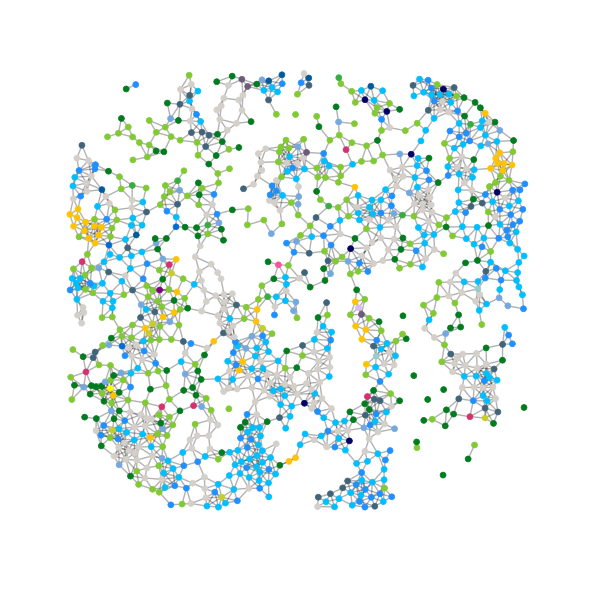

In [16]:
patient_id = Cell_graphs_discovery[0][0]
Adj = Cell_graphs_discovery[0][1]
cells_ = cells_discovery.loc[cells_discovery["patientID"] == patient_id].reset_index()
# For visualization propose, we set the diagonal of the adjacency matrix to be 0
np.fill_diagonal(Adj, 0)
# For visualization purpose, we only show edges with a weight higher than 0.01
Adj[Adj < 0.01] = 0
G = nx.from_numpy_array(Adj)
nx.set_node_attributes(G, cells_["coorX"], "coorX")
nx.set_node_attributes(G, cells_["coorY"], "coorY")
nx.set_node_attributes(G, cells_["meta_description"], "meta_description")
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
def get_pos(G):
    x = nx.get_node_attributes(G, "coorX")
    y = nx.get_node_attributes(G, "coorY")
    pos = {}
    for key, _ in x.items():
        pos[key] = (x[key], y[key])
    return pos
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


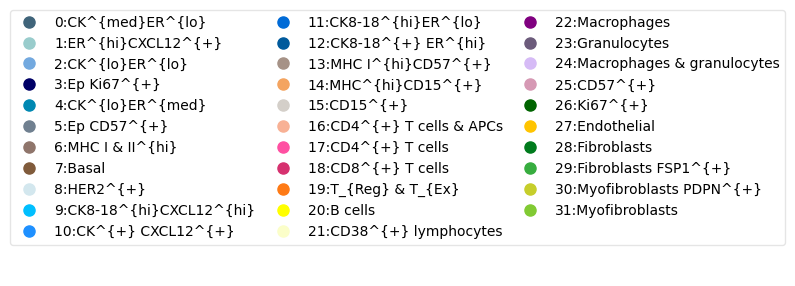

In [17]:
# Print Legend
fig, ax = plt.subplots(figsize=(10, 0.4), tight_layout=True)
func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
cell_types = [
    str(i) + ":" + reverse_dict(get_node_id("Danenberg", 'CellType'))[i]
    for i in range(len(get_node_id("Danenberg", 'CellType')))
]
handles = [
    func("o", get_node_color("Danenberg", 'CellType')[i.split(":")[1]])
    for i in cell_types
]
ax.legend(
    handles,
    cell_types,
    loc=3,
    framealpha=0.5,
    frameon=1,
    ncols=3,
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    mode="expand",
    borderaxespad=0.0,
    fontsize=10,
)
ax.axis("off")
plt.show()

# 2.Fit Soft-WL subtree kernel


In [7]:
if os.path.exists("fitted_soft_wl_subtree.pkl"):
    print("There is a pre-fitted soft wl subtree kernel. We will load it directly.")
    with open("fitted_soft_wl_subtree.pkl", "rb") as f:
        soft_wl_subtree_ = pickle.load(f)
else:
    print("There is no pre-fitted soft wl subtree kernel.")
    print("Go run `python 2_fit_wl_subtree_kernel.py` instead")


There is a pre-fitted soft wl subtree kernel. We will load it directly.


## Visualize TME Patterns

### Load Signature map and their distribution (Proportions)

In [8]:
Signatures = soft_wl_subtree_.Signatures
Histograms = soft_wl_subtree_.Histograms
Proportions = Histograms/np.sum(Histograms, axis=1, keepdims=True)
# Proportion of each pattern presented in each patient's cellular graphs
DF_proportion = pd.DataFrame(Proportions)
DF_proportion = DF_proportion.melt(
    var_name="pattern_id", value_name="proportion"

)


### Reordered tme patterns by tumor niches, immune niches, stromal niches, and interfacing niches (Only for visualization purpose)

In [11]:
# Define tumor niches, immune niches, stromal niches, and interfacing niches
threshold = 0.5  # does not impact the downstream analysis, only imapct the presentation of the signature map
tumor_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) > 0)
    & (np.sum(Signatures[:, 16:] > threshold, axis=1) == 0)
)[0]
immune_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 16:27] > threshold, axis=1) > 0)
    & (np.sum(Signatures[:, 27:] > threshold, axis=1) == 0)
)[0]
stromal_niche = np.where(
    (np.sum(Signatures[:, :16] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 16:27] > threshold, axis=1) == 0)
    & (np.sum(Signatures[:, 27:] > threshold, axis=1) > 0)
)[0]
interacting_niche = [
    i
    for i in range(Signatures.shape[0])
    if i not in np.concatenate([tumor_niche, immune_niche, stromal_niche])
]
print("There are {} identified TME patterns.".format(Signatures.shape[0]))
print(
    "There are {} tumor niches, {} immune niches, {} stromal niches, and {} interacting niches.".format(
        len(tumor_niche), len(immune_niche), len(stromal_niche), len(interacting_niche)
    )
)

There are 66 identified TME patterns.
There are 37 tumor niches, 4 immune niches, 11 stromal niches, and 14 interacting niches.


### Fig.4 Signature map and abundance

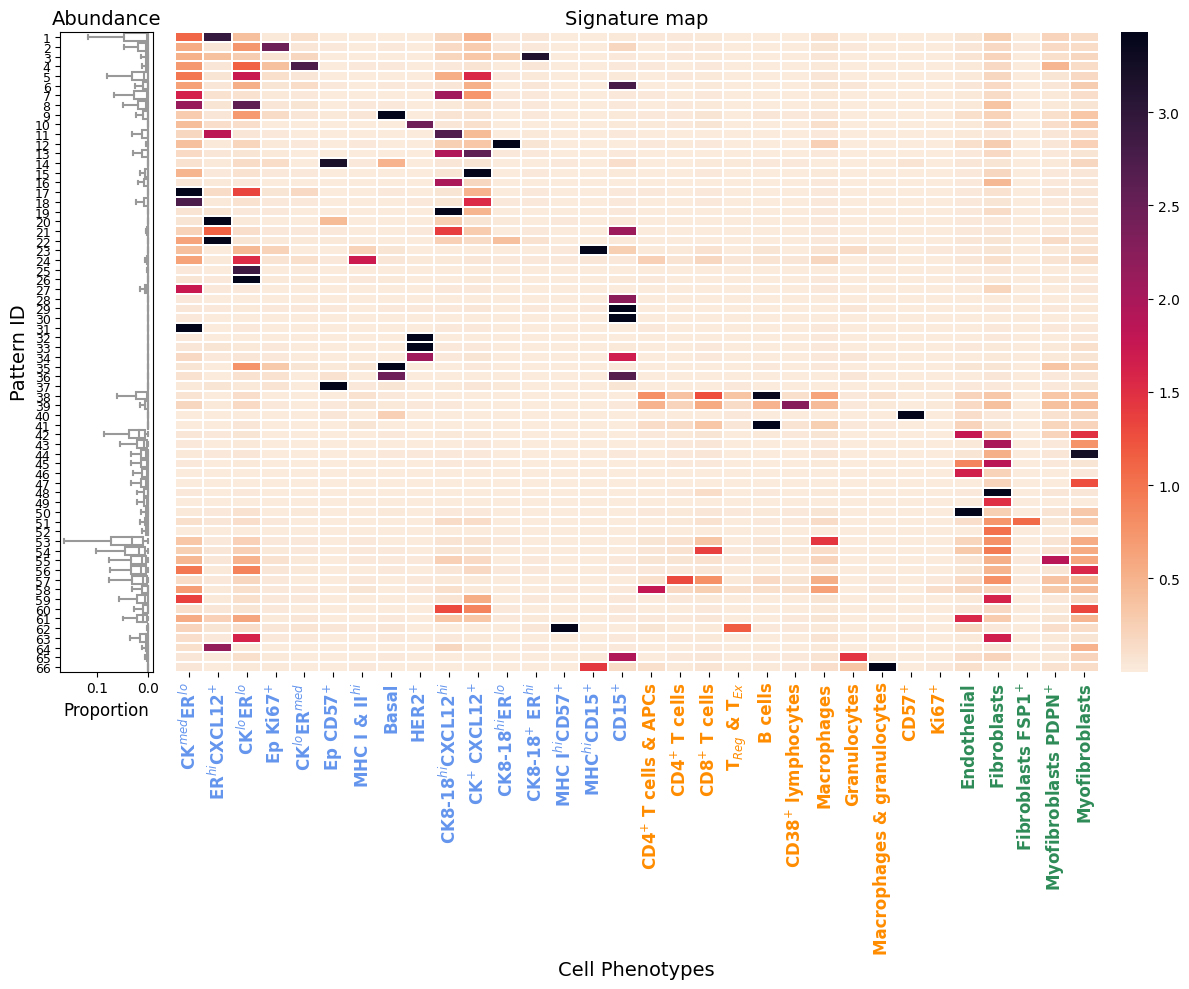

In [12]:
f, ax = plt.subplots(
    1,
    3,
    figsize=(12, 10),
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 10, 0.3]},
)
tme_pattern_orders = np.concatenate([tumor_niche, immune_niche, stromal_niche, interacting_niche])
sns.heatmap(
    Signatures[tme_pattern_orders, :],
    ax=ax[1],
    cmap="rocket_r",
    linewidth=0.005,
    cbar=True,
    cbar_ax=ax[2],
    edgecolor="black",
    vmax=np.percentile(Signatures, 99),
    vmin=np.percentile(Signatures, 5),
)

ax[1].get_yaxis().set_visible(False)
ax[1].set_title("Signature map", fontsize=14)
ax[1].set_xticklabels(
    Cell_types_displayed_Danenberg, rotation=90, fontsize=12, fontweight="bold"
)
ax[1].set_xlabel("Cell Phenotypes", fontsize=14)
xtickcolors = ["cornflowerblue"] * 16 + ["darkorange"] * 11 + ["seagreen"] * 5
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[2].get_xaxis().set_visible(False)

sns.boxplot(
    y="pattern_id",
    x="proportion",
    data=DF_proportion,
    showfliers=False,
    ax=ax[0],
    color="white",
    order=[str(i) for i in tme_pattern_orders],
    fliersize=0.5,
)
ax[0].set_xlabel("Proportion", fontsize=12)
ax[0].set_title("Abundance", fontsize=14)
ax[0].set_yticklabels([i + 1 for i in range(len(tme_pattern_orders))], fontsize=9)
ax[0].set_ylabel("Pattern ID", fontsize=14)
ax[0].invert_xaxis()
plt.show()

## Demonstrate Inter-patient Similarities

In [22]:
Similarity_matrix = soft_wl_subtree_.Similarity_matrix
Patient_Ids = [cellular_graph[0] for cellular_graph in soft_wl_subtree_.X]
print("The shape of the similarity matrix is", Similarity_matrix.shape)
print("There are {} patients".format(len(Patient_Ids)))

The shape of the similarity matrix is (379, 379)
There are 379 patients


In [23]:
template_patient_id = 'MB-0882'
template_image_id = 50
adj = soft_wl_subtree_.X[Patient_Ids.index(template_patient_id)][1] # The adjacency matrix of the template patient

cells_template = cells_discovery[cells_discovery['imageID'] == template_image_id].reset_index(drop=True)
assert len(cells_template) == adj.shape[0]
print("The number of cells in the template patient is", len(cells_template))

The number of cells in the template patient is 2118


In [24]:
# For visualization propose, we set the diagonal of the adjacency matrix to be 0
np.fill_diagonal(adj, 0) # Remove self loops
# For visualization purpose, we only show edges with a weight higher than 0.01
adj[adj < 0.01] = 0
G = nx.from_numpy_array(adj)
nx.set_node_attributes(G, cells_template["coorX"], "coorX")
nx.set_node_attributes(G, cells_template["coorY"], "coorY")
nx.set_node_attributes(G, cells_template["meta_description"], "meta_description")

### Fig.5.a Template patient

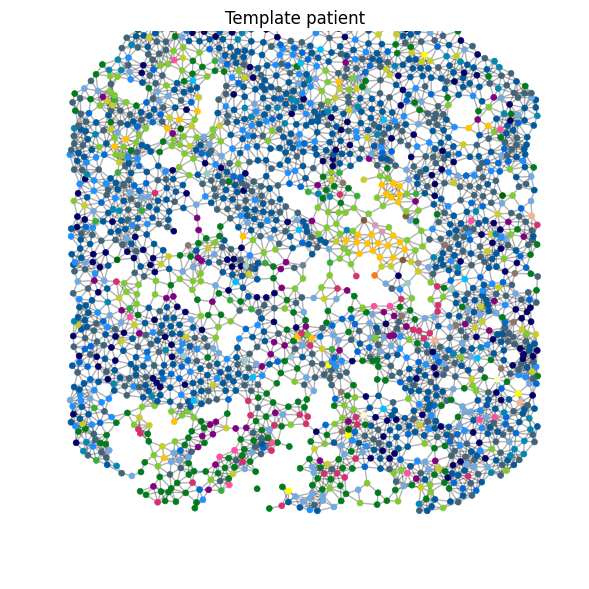

In [25]:
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    title = "Template patient",
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()

### Fig.5.b sorted similarity to template patient

Patient ID: MB-0598 Similarity: 0.9844688715760685 Rank: 1
Patient ID: MB-0354 Similarity: 0.7850040089449906 Rank: 17
Patient ID: MB-0083 Similarity: 0.13601860839247212 Rank: 72


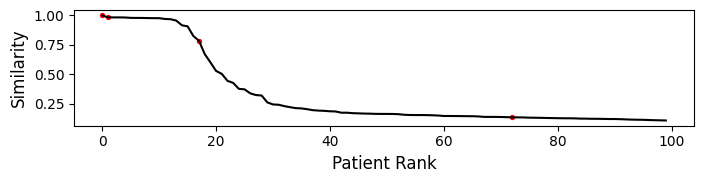

In [26]:
template_patient_index = Patient_Ids.index(template_patient_id) # The index of the template patient in the similarity matrix
Similarities_sorted = np.sort(Similarity_matrix[template_patient_index, :])[::-1] # Sort the similarities in descending order
Representative_patient_ids = ['MB-0262', 'MB-0356', 'MB-0290']
f, ax = plt.subplots(figsize=(8, 1.5))
ax.plot(Similarities_sorted[:100], color="k")
# TEMPLATE PATIENT
ax.scatter(0, Similarities_sorted[0], color="red", s=8)
# REPRESENTATIVE PATIENTS
Representative_patient_indices = (
    Patient_Ids.index(Representative_patient_ids[0]),
    Patient_Ids.index(Representative_patient_ids[1]),
    Patient_Ids.index(Representative_patient_ids[2]),
)
Patient_indices_sorted = np.argsort(Similarity_matrix[template_patient_index, :])[::-1]
Representative_patient_rankings = [
    list(Patient_indices_sorted).index(i) for i in Representative_patient_indices
]
for indice in Representative_patient_rankings:
    ax.scatter(indice, Similarities_sorted[indice], color="red", s=8)
    print("Patient ID:", Patient_Ids[indice], "Similarity:", Similarities_sorted[indice], "Rank:", indice)
ax.set_xlabel("Patient Rank", fontsize=12)
ax.set_ylabel("Similarity", fontsize=12)
plt.show()

### Fig.5.c A representative example


The image ID of the patient MB-0262 is 145
The number of cells in the template patient is 1652


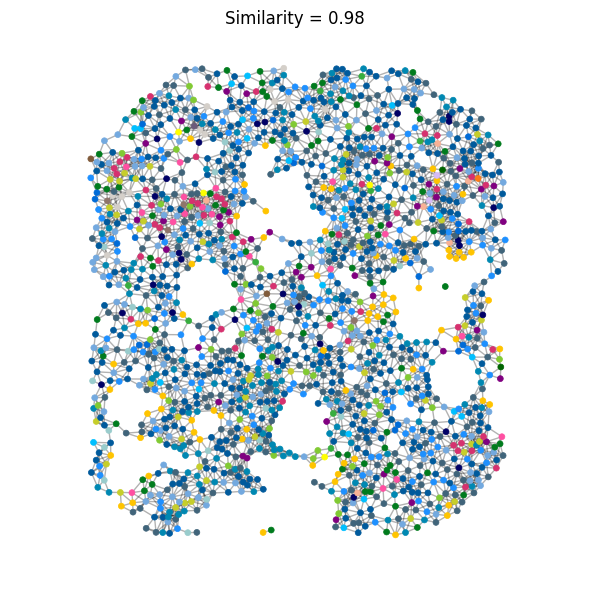

In [27]:
patient_id = "MB-0262"
image_id = cells_discovery[cells_discovery["patientID"] == patient_id]["imageID"].values[0]
print("The image ID of the patient", patient_id, "is", image_id)
adj = soft_wl_subtree_.X[Patient_Ids.index(patient_id)][1] # The adjacency matrix of the template patient
cells_ = cells_discovery[cells_discovery['imageID'] == image_id].reset_index(drop=True)
assert len(cells_) == adj.shape[0]
print("The number of cells in the template patient is", len(cells_))
np.fill_diagonal(adj, 0) # Remove self loops
adj[adj < 0.01] = 0
G = nx.from_numpy_array(adj)
nx.set_node_attributes(G, cells_["coorX"], "coorX")
nx.set_node_attributes(G, cells_["coorY"], "coorY")
nx.set_node_attributes(G, cells_["meta_description"], "meta_description")
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    title = 'Similarity = {:.2f}'.format(Similarity_matrix[template_patient_index, Patient_Ids.index(patient_id)]),
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()

### Fig.5.d A representative example

The image ID of the patient MB-0356 is 41
The number of cells in the template patient is 1244


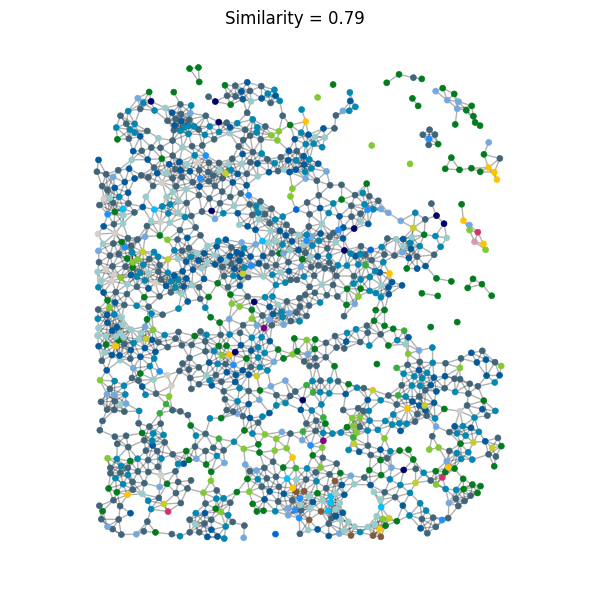

In [28]:
patient_id = "MB-0356"
image_id = cells_discovery[cells_discovery["patientID"] == patient_id]["imageID"].values[0]
print("The image ID of the patient", patient_id, "is", image_id)
adj = soft_wl_subtree_.X[Patient_Ids.index(patient_id)][1] # The adjacency matrix of the template patient
cells_ = cells_discovery[cells_discovery['imageID'] == image_id].reset_index(drop=True)
assert len(cells_) == adj.shape[0]
print("The number of cells in the template patient is", len(cells_))
np.fill_diagonal(adj, 0) # Remove self loops
adj[adj < 0.01] = 0
G = nx.from_numpy_array(adj)
nx.set_node_attributes(G, cells_["coorX"], "coorX")
nx.set_node_attributes(G, cells_["coorY"], "coorY")
nx.set_node_attributes(G, cells_["meta_description"], "meta_description")
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    title = 'Similarity = {:.2f}'.format(Similarity_matrix[template_patient_index, Patient_Ids.index(patient_id)]),
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()

### Fig.5.e A Representative Example

The image ID of the patient MB-0290 is 199
The number of cells in the template patient is 1348


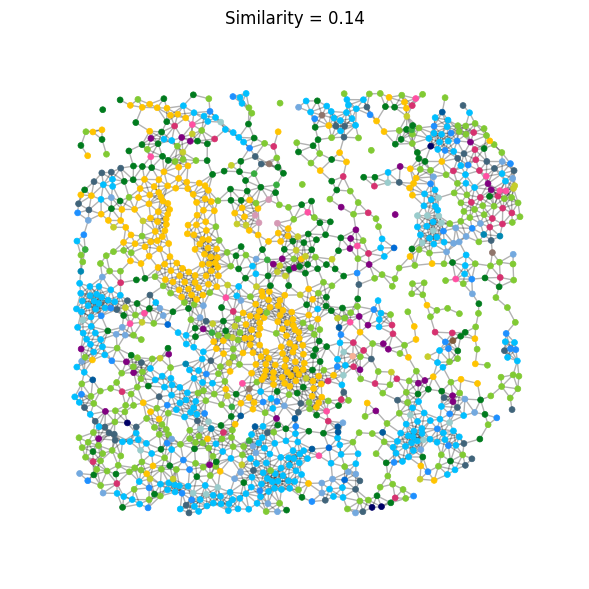

In [29]:
patient_id = "MB-0290"
image_id = cells_discovery[cells_discovery["patientID"] == patient_id]["imageID"].values[0]
print("The image ID of the patient", patient_id, "is", image_id)
adj = soft_wl_subtree_.X[Patient_Ids.index(patient_id)][1] # The adjacency matrix of the template patient
cells_ = cells_discovery[cells_discovery['imageID'] == image_id].reset_index(drop=True)
assert len(cells_) == adj.shape[0]
print("The number of cells in the template patient is", len(cells_))
np.fill_diagonal(adj, 0) # Remove self loops
adj[adj < 0.01] = 0
G = nx.from_numpy_array(adj)
nx.set_node_attributes(G, cells_["coorX"], "coorX")
nx.set_node_attributes(G, cells_["coorY"], "coorY")
nx.set_node_attributes(G, cells_["meta_description"], "meta_description")
f, ax = plt.subplots(
    1,
    1,
    figsize=(6, 6),
    tight_layout=True,
)
cell_color_dict = get_node_color("Danenberg", "CellType")
nx.draw_networkx_nodes(
    G,
    get_pos(G),
    node_size=18,
    node_color=[
        cell_color_dict[cell_type]
        for cell_type in list(nx.get_node_attributes(G, "meta_description").values())
    ],
    # edgecolors="black",
    linewidths=0.5,
    ax=ax,
)
nx.draw_networkx_edges(G, get_pos(G), ax=ax, alpha=0.3, width=1)
ax.set(
    title = 'Similarity = {:.2f}'.format(Similarity_matrix[template_patient_index, Patient_Ids.index(patient_id)]),
    xlim=(
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 - 350,
        (max(cells_["coorX"]) - min(cells_["coorX"])) / 2 + 350,
    ),
    ylim=(
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 - 350,
        (max(cells_["coorY"]) - min(cells_["coorY"])) / 2 + 350,
    ),
)
ax.set_axis_off()

# 3.Fit BiGraph model

## Construct Population Graph and generate patient subgroups

### Fit BiGraph model

In [9]:
bigraph_ = BiGraph(k_patient_clustering = 30)
population_graph_discovery, patient_subgroups_discovery = bigraph_.fit_transform(
    cells_discovery
)

There is a soft wl subtree kernel fitted before. We will load it directly.
If you want to re-calculate the similarity matrix, please delete the file '3_fit_wl_subtree_kernel.py'.
An overview of the input cellular graphs is as follows: 
	 379 unique patients.
	 32 unique cell types.
	 670335 total cells, 1768.69 cells per patient.
An overview of the identified patterns is as follows: 
	 66 discovered patterns.
Start generating population graph.
Initialized Population_Graph, k_clustering =  30 , k_estimate =  3 , resolution =  1.0 , size_smallest_cluster =  10 , seed =  1
Population graph generated.
Start detecting patient subgroups.
Patient subgroups detected.
There are 7 patient subgroups, 0 ungrouped patients
Start finding characteristic patterns for each patient subgroup.
Characteristic patterns found.


### Survival analysis of patient subgroups

In [10]:
assert bigraph_.Patient_ids == patient_ids_discovery
cph = CoxPHFitter()
lengths_discovery = [
    clinical_Danenberg.loc[
        clinical_Danenberg["metabric_id"] == i, "Disease-specific Survival (Months)"
    ].values[0]
    for i in patient_ids_discovery
]
statuses_discovery = [
    (
        0
        if clinical_Danenberg.loc[
            clinical_Danenberg["metabric_id"] == i, "Disease-specific Survival Status"
        ].values[0]
        == "0:LIVING"
        else 1
    )
    for i in patient_ids_discovery
]
for i in range(len(patient_subgroups_discovery)):
    subgroup = patient_subgroups_discovery[i]
    patient_ids = subgroup["patient_ids"]
    DF = pd.DataFrame(
        {
            "length": lengths_discovery,
            "status": statuses_discovery,
            "community": np.isin(patient_ids_discovery, patient_ids),
        }
    )
    cph.fit(
        DF,
        duration_col="length",
        event_col="status",
        show_progress=False,
    )
    patient_subgroups_discovery[i]["hr"] = cph.hazard_ratios_["community"]
    patient_subgroups_discovery[i]["p"] = cph.summary["p"]["community"]
    patient_subgroups_discovery[i]["hr_lower"] = np.exp(
        cph.confidence_intervals_["95% lower-bound"]["community"]
    )
    patient_subgroups_discovery[i]["hr_upper"] = np.exp(
        cph.confidence_intervals_["95% upper-bound"]["community"]
    )

patient_subgroups_discovery = sorted(
    patient_subgroups_discovery, key=lambda x: x["hr"], reverse=True
)
for i in range(len(patient_subgroups_discovery)):
    patient_subgroups_discovery[i]["subgroup_id"] = "S" + str(i + 1)
    print(
        "Patient subgroup S{}: N = {}, HR = {:.2f} ({:.2f}-{:.2f}), p = {:.2e}".format(
            i + 1,
            len(patient_subgroups_discovery[i]["patient_ids"]),
            patient_subgroups_discovery[i]["hr"],
            patient_subgroups_discovery[i]["hr_lower"],
            patient_subgroups_discovery[i]["hr_upper"],
            patient_subgroups_discovery[i]["p"],
        )
    )

Patient subgroup S1: N = 26, HR = 2.43 (1.43-4.11), p = 9.53e-04
Patient subgroup S2: N = 48, HR = 1.67 (1.06-2.65), p = 2.84e-02
Patient subgroup S3: N = 23, HR = 1.20 (0.59-2.45), p = 6.19e-01
Patient subgroup S4: N = 73, HR = 1.15 (0.76-1.75), p = 5.15e-01
Patient subgroup S5: N = 61, HR = 0.97 (0.61-1.53), p = 8.87e-01
Patient subgroup S6: N = 51, HR = 0.62 (0.33-1.14), p = 1.24e-01
Patient subgroup S7: N = 97, HR = 0.51 (0.32-0.82), p = 5.38e-03


### Fig.6.a Plot Population graph 

Initialized Population_Graph, k_clustering =  20 , k_estimate =  3 , resolution =  1.0 , size_smallest_cluster =  10 , seed =  1


[[Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, ''),
  Text(1.0, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.8, 0, ''),
  Text(-0.6, 0, ''),
  Text(-0.3999999999999999, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.20000000000000018, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')],
 [Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')]]

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


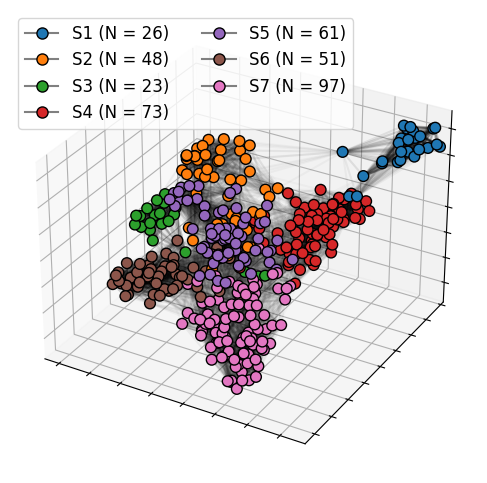

In [32]:
subgroup_ids_discovery = np.zeros(len(patient_ids_discovery), dtype=object)
subgroup_ids_discovery[:] = "Unclassified"
for i in range(len( patient_subgroups_discovery)):
    subgroup = patient_subgroups_discovery[i]
    subgroup_id = subgroup["subgroup_id"]
    patient_ids = subgroup["patient_ids"]
    subgroup_ids_discovery[np.isin(patient_ids_discovery, patient_ids)] = subgroup_id
# For visualization purpose, we make nodes distant from each other
population_graph_for_visualization  = Population_Graph(
    k_clustering=20
).generate(
    bigraph_.Similarity_matrix, patient_ids_discovery
)  # generate population graph
pos = nx.spring_layout(
    population_graph_for_visualization,
    seed=3,
    k=1 / (np.sqrt(397)) * 10,
    iterations=100,
    dim=3,
)
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(population_graph_for_visualization)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in population_graph_for_visualization.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette_Bigraph[i] for i in subgroup_ids_discovery],
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(population_graph_for_visualization.edges())
edge_alpha = [
    (
        0.2 * population_graph_for_visualization[u][v]["weight"]
        if population_graph_for_visualization[u][v]["weight"] > 0.1
        else 0
    )
    for u, v in edge_list
]
for i in range(len(edge_list)):
    u, v = edge_list[i]
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color="k")

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)
handles = []
if np.sum(subgroup_ids_discovery == "Unclassified") > 0:
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="white",
            markerfacecolor="white",
            label="Unclassified (N = {})".format(
                np.sum(subgroup_ids_discovery == "Unclassified")
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )
for subgroup in patient_subgroups_discovery:
    subgroup_id = subgroup["subgroup_id"]
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="grey",
            markerfacecolor=color_palette_Bigraph[subgroup_id],
            label="{} (N = {})".format(
                subgroup_id, np.sum(subgroup_ids_discovery == subgroup_id)
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )

ax.legend(handles=handles, fontsize=12, ncols=2)
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])


### Fig.6.b Plot Survival curves 

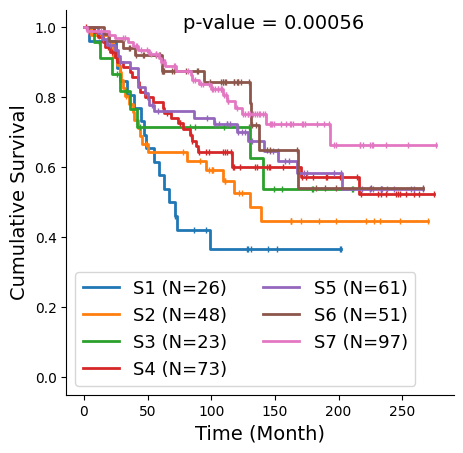

In [39]:
kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5,5))
for subgroup in patient_subgroups_discovery:
    subgroup_id = subgroup["subgroup_id"]
    length_A, event_observed_A = (
        np.array(lengths_discovery)[subgroup_ids_discovery == subgroup_id],
        np.array(statuses_discovery)[subgroup_ids_discovery == subgroup_id],
    )
    label = "{} (N={})".format(
        subgroup["subgroup_id"], np.sum(subgroup_ids_discovery == subgroup_id)
    )
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        color=color_palette_Bigraph[subgroup_id],
        show_censors=True,
        linewidth=2,
        censor_styles={"ms": 5, "marker": "|"},
    )
log_rank_test = multivariate_logrank_test(
    np.array(lengths_discovery)[subgroup_ids_discovery != 0],
    np.array(subgroup_ids_discovery)[subgroup_ids_discovery != 0],
    np.array(statuses_discovery)[subgroup_ids_discovery != 0],
)
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize=13)
ax.text(
    x=0.3,
    y=0.95,
    s="p-value = {:.5f}".format(p_value),
    fontsize=14,
    transform=ax.transAxes,
)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
sns.despine()

### Fig.6.c Plot hazard ratios 

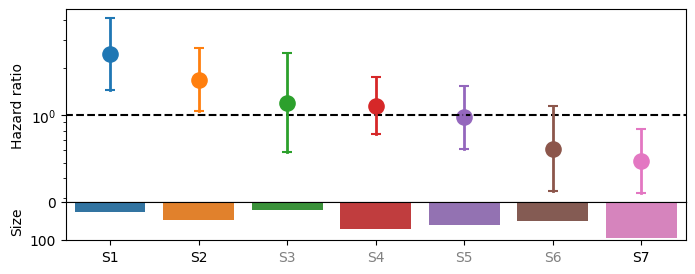

In [40]:
# Plot hazard ratio
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(patient_subgroups_discovery), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(patient_subgroups_discovery)):
    subgroup = patient_subgroups_discovery[i]
    subgroup_id = subgroup['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            subgroup["hr"],
            subgroup["hr_lower"],
            subgroup["hr_upper"],
            subgroup["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette_Bigraph[subgroup_id], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette_Bigraph[subgroup_id], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette_Bigraph[subgroup_id], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette_Bigraph[subgroup_id], s=60, marker="_")
    N.append(np.sum(subgroup_ids_discovery == subgroup_id))
    xticklabels.append("{}".format(subgroup_id))
    if p < 0.05:
        xtickcolors.append("k")
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(patient_subgroups_discovery)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette_Bigraph, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

## Correlation With Clinical Data

### Extract clinical subtype for each patient

In [35]:
clinical_subtypes_discovery = np.zeros(len(patient_ids_discovery), dtype=object)
clinical_subtypes_discovery[:] = 'Unknown'
for i in range(len(patient_ids_discovery)):
    patient_id = patient_ids_discovery[i]
    er = clinical_Danenberg.loc[clinical_Danenberg.metabric_id == patient_id, 'ER Status'].values[0]
    pr = clinical_Danenberg.loc[clinical_Danenberg.metabric_id == patient_id, 'PR Status'].values[0]
    her2 = clinical_Danenberg.loc[clinical_Danenberg.metabric_id == patient_id, 'HER2 Status'].values[0]
    if  her2 == "Positive":
        clinical_subtypes_discovery[i] = 'HER2+' # Her2+
    if (er == "Positive" or pr == "Positive") and her2 == "Negative":
        clinical_subtypes_discovery[i] = 'HR+/HER2-' # HR+/HER2-
    elif (er == "Negative" and pr == "Negative") and her2 == "Negative":
        clinical_subtypes_discovery[i] = 'TNBC' # TNBC
print(
    "{} patients in total, {} Unkonw, {} HER2+, {} HR+/HER2-, {} TNBC".format(
        len(clinical_subtypes_discovery),
              np.sum(clinical_subtypes_discovery == 'Unknown'),
        np.sum(clinical_subtypes_discovery == 'HER2+'),
        np.sum(clinical_subtypes_discovery == 'HR+/HER2-'),
        np.sum(clinical_subtypes_discovery == 'TNBC'),
  

    )
)

379 patients in total, 54 Unkonw, 32 HER2+, 243 HR+/HER2-, 50 TNBC


###  Table 1: Averaged inter-patient similarity

In [36]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_ != -1])


Similarity_matrix = bigraph_.Similarity_matrix
print(
    "The mutual similarity of the population graph is {:.2f}".format(
        caculate_mutual_similarity(Similarity_matrix)
    )
)

Gram_matrix_ = Similarity_matrix[
    np.array(np.where(clinical_subtypes_discovery == 'HER2+')[0].tolist()), :
][:, np.array(np.where(clinical_subtypes_discovery == 'HER2+')[0].tolist())]
print(
    "{} HER2+ patients, averaged Intra-group similarity is {:.2f} ".format(
        Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)
    )
)

Gram_matrix_ = Similarity_matrix[
    np.array(np.where(clinical_subtypes_discovery == 'HR+/HER2-')[0].tolist()), :
][:, np.array(np.where(clinical_subtypes_discovery == 'HR+/HER2-')[0].tolist())]
print(
    "{} HR+/HER2- patients, averaged Intra-group similarity is {:.2f} ".format(
        Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)
    )
)

Gram_matrix_ = Similarity_matrix[
    np.array(np.where(clinical_subtypes_discovery == 'TNBC')[0].tolist()), :
][:, np.array(np.where(clinical_subtypes_discovery == 'TNBC')[0].tolist())]
print(
    "{} TNBC patients, averaged Intra-group similarity is {:.2f} ".format(
        Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)
    )
)

The mutual similarity of the population graph is 0.18
32 HER2+ patients, averaged Intra-group similarity is 0.43 
243 HR+/HER2- patients, averaged Intra-group similarity is 0.20 
50 TNBC patients, averaged Intra-group similarity is 0.15 


In [37]:
for subgroup_id in ["S1", "S2", "S3", "S4", "S5", "S6", "S7"]:
    Gram_matrix_ = Similarity_matrix[
        np.array(np.where(subgroup_ids_discovery == subgroup_id)[0].tolist()), :
    ][:, np.array(np.where(subgroup_ids_discovery == subgroup_id)[0].tolist())]
    print(
        "{} patients in {}, averaged Intra-group similarity is {:.2f} ".format(
           subgroup_id, Gram_matrix_.shape[0], caculate_mutual_similarity(Gram_matrix_)
        )
    )



S1 patients in 26, averaged Intra-group similarity is 0.75 
S2 patients in 48, averaged Intra-group similarity is 0.26 
S3 patients in 23, averaged Intra-group similarity is 0.73 
S4 patients in 73, averaged Intra-group similarity is 0.45 
S5 patients in 61, averaged Intra-group similarity is 0.32 
S6 patients in 51, averaged Intra-group similarity is 0.61 
S7 patients in 97, averaged Intra-group similarity is 0.37 


### Fig 7.a Paint Population graph with clinical subtypes

Initialized Population_Graph, k_clustering =  20 , k_estimate =  3 , resolution =  1.0 , size_smallest_cluster =  10 , seed =  1


/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1019: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(x)


[[Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, ''),
  Text(1.0, 0, '')],
 [Text(-1.0, 0, ''),
  Text(-0.8, 0, ''),
  Text(-0.6, 0, ''),
  Text(-0.3999999999999999, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.20000000000000018, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')],
 [Text(-0.8, 0, ''),
  Text(-0.6000000000000001, 0, ''),
  Text(-0.4, 0, ''),
  Text(-0.19999999999999996, 0, ''),
  Text(0.0, 0, ''),
  Text(0.19999999999999996, 0, ''),
  Text(0.40000000000000013, 0, ''),
  Text(0.6000000000000001, 0, ''),
  Text(0.8, 0, '')]]

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


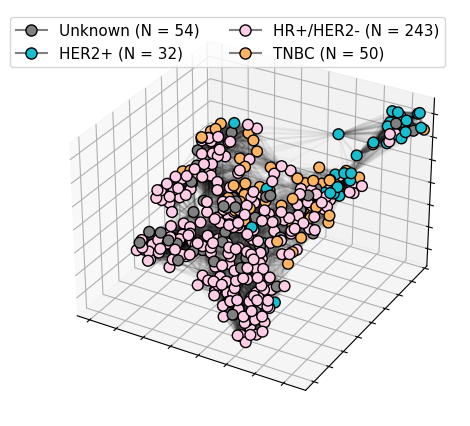

In [42]:
# For visualization purpose, we make nodes distant from each other
population_graph_for_visualization  = Population_Graph(
    k_clustering=20
).generate(
    bigraph_.Similarity_matrix, patient_ids_discovery
)  # generate population graph
pos = nx.spring_layout(
    population_graph_for_visualization,
    seed=3,
    k=1 / (np.sqrt(397)) * 10,
    iterations=100,
    dim=3,
)
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot(111, projection="3d")
node_xyz = np.array([pos[v] for v in sorted(population_graph_for_visualization)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in population_graph_for_visualization.edges()])
ax.scatter(
    *node_xyz.T,
    s=60,
    c=[color_palette_clinical[i] for i in clinical_subtypes_discovery],
    edgecolors="black",
    linewidths=1,
    alpha=1
)
edge_list = list(population_graph_for_visualization.edges())
edge_alpha = [
    (
        0.2 * population_graph_for_visualization[u][v]["weight"]
        if population_graph_for_visualization[u][v]["weight"] > 0.1
        else 0
    )
    for u, v in edge_list
]
for i in range(len(edge_list)):
    u, v = edge_list[i]
    ax.plot(*edge_xyz[i].T, alpha=edge_alpha[i], color="k")

ax.set(
    xlim=(np.min(node_xyz[:, 0]), np.max(node_xyz[:, 0])),
    ylim=(np.min(node_xyz[:, 1]), np.max(node_xyz[:, 1])),
    zlim=(np.min(node_xyz[:, 2]), np.max(node_xyz[:, 2])),
)
handles = []
for clinical_subtype_id in ['Unknown', 'HER2+', 'HR+/HER2-', 'TNBC']:
    handles.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color="grey",
            markerfacecolor=color_palette_clinical[clinical_subtype_id],
            label="{} (N = {})".format(
                clinical_subtype_id, np.sum(clinical_subtypes_discovery == clinical_subtype_id)
            ),
            markeredgecolor="black",
            markeredgewidth=1,
            markersize=8,
        )
    )

ax.legend(handles=handles, fontsize=11, ncols=2)
ax.set(yticklabels=[], xticklabels=[], zticklabels=[])


### Fig.7.c Spearmanr correlation 

Clinical Subtype: HER2+, Subgroup: S1, correlation_coefficient: 0.63, p_val: 1.83e-43
Clinical Subtype: HER2+, Subgroup: S7, correlation_coefficient: -0.16, p_val: 2.27e-03
Clinical Subtype: TNBC, Subgroup: S2, correlation_coefficient: 0.23, p_val: 8.36e-06
Clinical Subtype: TNBC, Subgroup: S4, correlation_coefficient: 0.21, p_val: 5.80e-05
Clinical Subtype: TNBC, Subgroup: S7, correlation_coefficient: -0.16, p_val: 2.15e-03
Clinical Subtype: HR+/HER2-, Subgroup: S1, correlation_coefficient: -0.28, p_val: 4.86e-08
Clinical Subtype: HR+/HER2-, Subgroup: S7, correlation_coefficient: 0.17, p_val: 6.66e-04


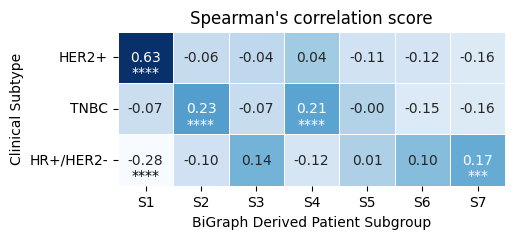

In [ ]:
import numpy as np

spearmanr_corr = np.zeros((3, 7))
P_value = np.zeros((3, 7))
for i in range(3):
    clinical_subtype = ["HER2+", "TNBC", "HR+/HER2-"][i]
    for j in range(7):
        subgroup_id = ["S1", "S2", "S3", "S4", "S5", "S6", "S7"][j]
        variable_1 = (np.array(clinical_subtypes_discovery) == clinical_subtype) 
        variable_2 = (np.array(subgroup_ids_discovery) == subgroup_id)
        correlation_coefficient, p_value = spearmanr(variable_1, variable_2)
        spearmanr_corr[i,j] = correlation_coefficient
        P_value[i,j] = p_value
        if p_value < 0.05/(3*7):
            print(
                    "Clinical Subtype: {}, Subgroup: {}, correlation_coefficient: {:.2f}, p_val: {:.2e}".format(
                        clinical_subtype, subgroup_id, correlation_coefficient, p_value
                    )
                )

       
f, ax = plt.subplots(figsize=(5, 2))
sns.heatmap(spearmanr_corr, annot=True, fmt=".2f", cmap="Blues", cbar = False, linewidths=0.5, linecolor='white', ax=ax, vmax = 0.6)
ax.text(0 + 0.5, 0+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )
ax.text(0 + 0.5, 2+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'black'
                 )

ax.text(1 + 0.5, 1+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )
ax.text(3 + 0.5, 1+0.8 , '****',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )

ax.text(6 + 0.5, 2+0.8 , '***',
                 horizontalalignment='center',
                 verticalalignment='center',
                 color = 'white'
                 )


ax.set_xlabel("BiGraph Derived Patient Subgroup")
ax.set_ylabel("Clinical Subtype")
ax.set_xticklabels(["S1", "S2", "S3", "S4", "S5", "S6", "S7"] ,rotation=0)
ax.set_yticklabels(["HER2+", "TNBC", "HR+/HER2-"], rotation=0)
ax.set(title = "Spearman's correlation score")
plt.show()

### Fig.8.a BiGraph enhances the risk stratification of clinical subtype (HER2+ and S1)

     test_statistic         p   -log2(p)
1 2        3.412484  0.064705   3.949979
  3       14.702734  0.000126  12.955849
2 3        0.600978  0.438205   1.190321


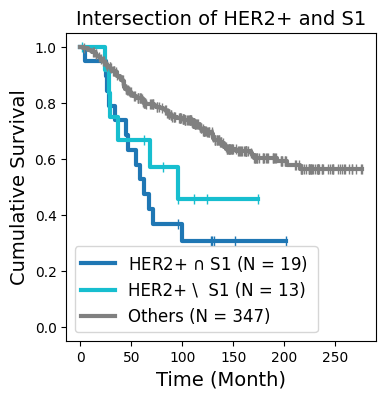

In [ ]:
clinical_subtype = "HER2+"
subgroup_id = 'S1'
lengths_discovery = np.array(lengths_discovery)
statuses_discovery = np.array(statuses_discovery)
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (subgroup_ids_discovery == subgroup_id) & (clinical_subtypes_discovery == clinical_subtype)
length_A, event_observed_A = (
    lengths_discovery[Indices_A],
    statuses_discovery[Indices_A],
)
label = r"{} $\cap$ {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)

Indices_C = (subgroup_ids_discovery != subgroup_id) & (clinical_subtypes_discovery == clinical_subtype)
length_C, event_observed_C = (
    lengths_discovery[Indices_C],
    statuses_discovery[Indices_C],
)
label = r"{} \  {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)

Indices_B = (
    (clinical_subtypes_discovery != clinical_subtype)
)
length_B, event_observed_B = (
    lengths_discovery[Indices_B],
    statuses_discovery[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,  
)


groups = np.zeros_like(clinical_subtypes_discovery, dtype=int)
groups[:] = 1
groups[((clinical_subtypes_discovery == clinical_subtype)) & (subgroup_ids_discovery != subgroup_id)] = 2
groups[((clinical_subtypes_discovery == clinical_subtype)) & (subgroup_ids_discovery == subgroup_id)] = 3


log_rank_test = pairwise_logrank_test(
    lengths_discovery,
    groups,
    statuses_discovery,
)
print(log_rank_test.summary)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
ax.set_title("Intersection of {} and {}".format(clinical_subtype, subgroup_id), fontsize=14)
plt.show()

### Fig.8.a BiGraph enhances the risk stratification of clinical subtype (TNBC and S2)

     test_statistic         p  -log2(p)
1 2        1.842686  0.174636  2.517573
  3        9.683296  0.001860  9.070864
2 3        1.267840  0.260172  1.942461


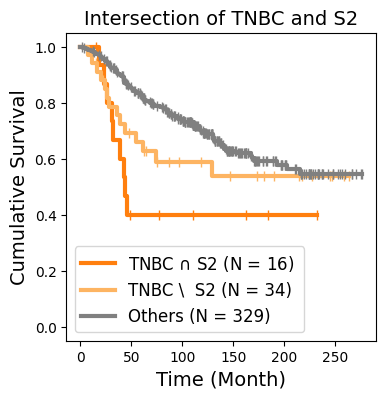

In [ ]:
clinical_subtype = "TNBC"
subgroup_id = 'S2'
lengths_discovery = np.array(lengths_discovery)
statuses_discovery = np.array(statuses_discovery)
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (subgroup_ids_discovery == subgroup_id) & (clinical_subtypes_discovery == clinical_subtype)
length_A, event_observed_A = (
    lengths_discovery[Indices_A],
    statuses_discovery[Indices_A],
)
label = r"{} $\cap$ {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)

Indices_C = (subgroup_ids_discovery != subgroup_id) & (clinical_subtypes_discovery == clinical_subtype)
length_C, event_observed_C = (
    lengths_discovery[Indices_C],
    statuses_discovery[Indices_C],
)
label = r"{} \  {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)

Indices_B = (
    (clinical_subtypes_discovery != clinical_subtype)
)
length_B, event_observed_B = (
    lengths_discovery[Indices_B],
    statuses_discovery[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,  
)


groups = np.zeros_like(clinical_subtypes_discovery, dtype=int)
groups[:] = 1
groups[((clinical_subtypes_discovery == clinical_subtype)) & (subgroup_ids_discovery != subgroup_id)] = 2
groups[((clinical_subtypes_discovery == clinical_subtype)) & (subgroup_ids_discovery == subgroup_id)] = 3


log_rank_test = pairwise_logrank_test(
    lengths_discovery,
    groups,
    statuses_discovery,
)
print(log_rank_test.summary)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
ax.set_title("Intersection of {} and {}".format(clinical_subtype, subgroup_id), fontsize=14)
plt.show()

### Fig.8.a BiGraph enhances the risk stratification of clinical subtype (HR+/HER2-+ and S7)

     test_statistic         p   -log2(p)
1 2        3.695535  0.054558   4.196058
  3       12.991031  0.000313  11.641612
2 3        4.630194  0.031414   4.992448


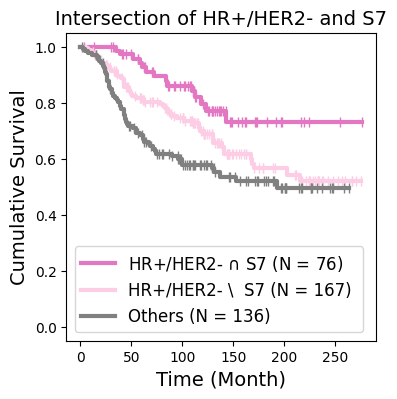

In [ ]:
clinical_subtype = "HR+/HER2-"
subgroup_id = 'S7'
lengths_discovery = np.array(lengths_discovery)
statuses_discovery = np.array(statuses_discovery)
f, ax = plt.subplots(figsize=(4,4))
kmf = KaplanMeierFitter()
Indices_A = (subgroup_ids_discovery == subgroup_id) & (clinical_subtypes_discovery == clinical_subtype)
length_A, event_observed_A = (
    lengths_discovery[Indices_A],
    statuses_discovery[Indices_A],
)
label = r"{} $\cap$ {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_A))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_Bigraph[subgroup_id],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",
    linewidth=3,
    label=label,
)

Indices_C = (subgroup_ids_discovery != subgroup_id) & (clinical_subtypes_discovery == clinical_subtype)
length_C, event_observed_C = (
    lengths_discovery[Indices_C],
    statuses_discovery[Indices_C],
)
label = r"{} \  {} (N = {}) ".format(clinical_subtype, subgroup_id, len(length_C))
kmf.fit(length_C, event_observed_C, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color=color_palette_clinical[clinical_subtype],
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    markerfacecolor="grey",

    linewidth=3,
)

Indices_B = (
    (clinical_subtypes_discovery != clinical_subtype)
)
length_B, event_observed_B = (
    lengths_discovery[Indices_B],
    statuses_discovery[Indices_B],
)
label = r"Others (N = {})".format(len(length_B))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(
    ax=ax,
    ci_show=False,
    color="grey",
    show_censors=True,
    censor_styles={"ms": 7, "marker": "|"},
    linewidth=3,
    label=label,  
)


groups = np.zeros_like(clinical_subtypes_discovery, dtype=int)
groups[:] = 1
groups[((clinical_subtypes_discovery == clinical_subtype)) & (subgroup_ids_discovery != subgroup_id)] = 2
groups[((clinical_subtypes_discovery == clinical_subtype)) & (subgroup_ids_discovery == subgroup_id)] = 3


log_rank_test = pairwise_logrank_test(
    lengths_discovery,
    groups,
    statuses_discovery,
)
print(log_rank_test.summary)


ax.legend(fontsize=12)
ax.set_xlabel("Time (Month)", fontsize=14)
ax.set_ylabel("Cumulative Survival", fontsize=14)
ax.set(
    ylim=(-0.05, 1.05),
)
ax.set_title("Intersection of {} and {}".format(clinical_subtype, subgroup_id), fontsize=14)
plt.show()

# 4.Explain BiGraph model

## Demonstrating how characteristic patterns are extracted

### Fig.A.2 Distribution of TME pattern expression in each of the seven patient subgroups


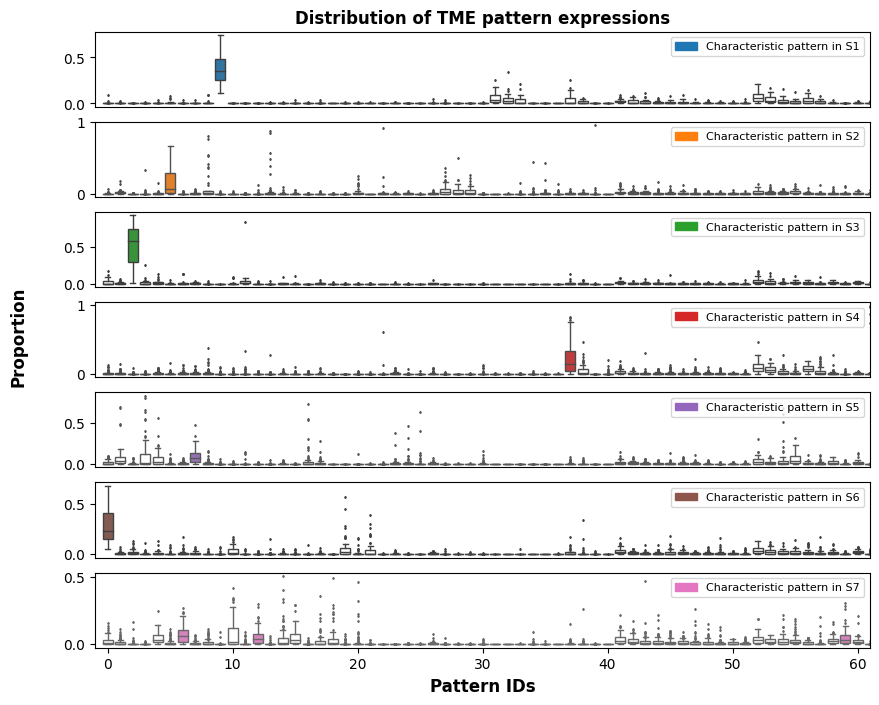

In [18]:
f, ax = plt.subplots(len(patient_subgroups_discovery), 1, figsize=(10,8), sharex=True)
for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]['subgroup_id']
    proportions_in_group = patient_subgroups_discovery[i]['proportions_in_group']
    hodges_lehmanns = patient_subgroups_discovery[i]['hodges_lehmanns']
    characteristic_patterns = patient_subgroups_discovery[i]['characteristic_patterns']
    DF_proportion = pd.DataFrame(proportions_in_group)
    DF_proportion = DF_proportion.melt(var_name = 'pattern_id', value_name = 'proportion')
    DF_proportion["characteristic"] = np.isin(DF_proportion['pattern_id'], characteristic_patterns)
    sns.boxplot(
        data=DF_proportion,
        x="pattern_id",
        y="proportion",
        ax=ax[i],
        hue="characteristic",
        showfliers=True,
        fliersize=1,
        palette={True: color_palette_Bigraph[subgroup_id], False: "white"},
        dodge =False,
        linewidth=1,
        order = tme_pattern_orders
    )
    handles = [
        patches.Rectangle(
            (0.4, 0.1),
            1,
            1,
            edgecolor=color_palette_Bigraph[subgroup_id],
            facecolor=color_palette_Bigraph[subgroup_id],
            label="Characteristic pattern in {}".format(subgroup_id),
        ),
    ]
    ax[i].legend(handles=handles, fontsize=8, loc = 'upper right')
    ax[i].set_ylabel("", fontsize=8)
    ax[i].get_xaxis().set_visible(False)
    ax[i].set(xlim = (-1, 61))
    
ax[0].set_title("Distribution of TME pattern expressions".format(subgroup_id), fontweight = 'bold')
ax[-1].get_xaxis().set_visible(True)
ax[-1].set(
    xticks = [0,10,20,30,40,50,60],
    xticklabels = [0,10,20,30,40,50,60],
)
ax[-1].set_xlabel("Pattern IDs", fontsize=12, fontweight = 'bold')
f.text(0.04, 0.5, 'Proportion', va='center', rotation='vertical', fontweight = 'bold', fontsize = 12)
plt.show()

### Fig.A.3 Hodge-lehmann statistics of TME pattern expressions in each of the seven patient subgroups

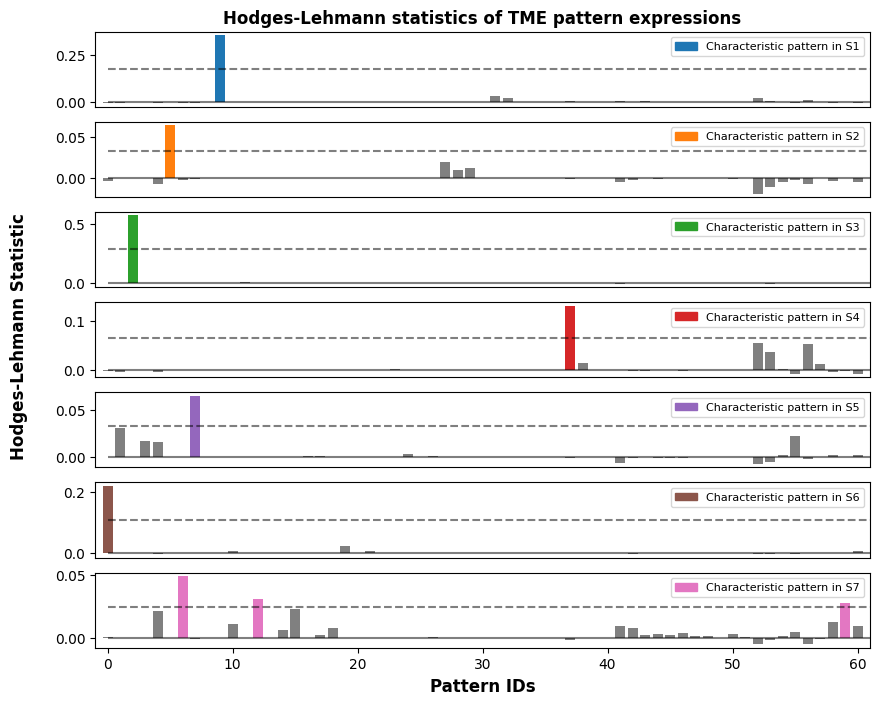

In [19]:
f, ax = plt.subplots(
    len(patient_subgroups_discovery),
    1,
    figsize=(10,8),
    sharex=True,
)
for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    hodges_lehmanns = patient_subgroups_discovery[i]["hodges_lehmanns"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    ax[i].bar(
        np.arange(len(hodges_lehmanns)),
        np.array(hodges_lehmanns)[tme_pattern_orders],
        color=[
            (
                color_palette_Bigraph[subgroup_id]
                if i in characteristic_patterns
                else "grey"
            )
            for i in tme_pattern_orders
        ],
    )
    handles = [
        patches.Rectangle(
            (0.6, 0.2),
            1,
            1,
            edgecolor=color_palette_Bigraph[subgroup_id],
            facecolor=color_palette_Bigraph[subgroup_id],
            label="Characteristic pattern in {}".format(subgroup_id),
        ),
    ]
    ax[i].legend(handles=handles, fontsize=8, loc="upper right")
    ax[i].set_ylabel("", fontsize=8)
    ax[i].get_xaxis().set_visible(False)
    ax[i].set(xlim=(-1, 61))
    ax[i].hlines(
        0.5 * np.max(hodges_lehmanns), 0, len(hodges_lehmanns), color="k", linestyle="--", alpha = 0.5
    )
    ax[i].hlines(0, 0, len(hodges_lehmanns), color="k", alpha = 0.5)
    

ax[0].set_title("Hodges-Lehmann statistics of TME pattern expressions", fontweight="bold")
ax[-1].get_xaxis().set_visible(True)
ax[-1].set_xlabel("Pattern IDs", fontsize=10, fontweight = 'bold')
ax[-1].set(
    xticks=[0, 10, 20, 30, 40, 50, 60],
    xticklabels=[0, 10, 20, 30, 40, 50, 60],
)
ax[-1].set_xlabel("Pattern IDs", fontsize=12)
f.text(0.04, 0.5, 'Hodges-Lehmann Statistic', va='center', rotation='vertical', fontweight = 'bold', fontsize = 12)
plt.show()

## Visualize characteristic patterns


###  Fig.9 Signature of characteristic patterns in each patient subgroup

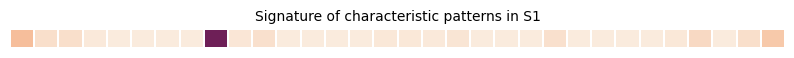

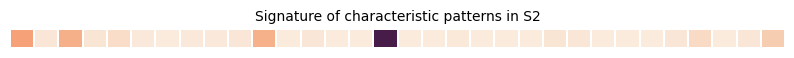

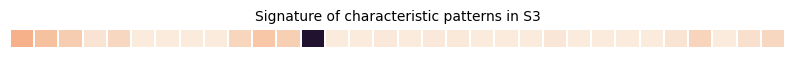

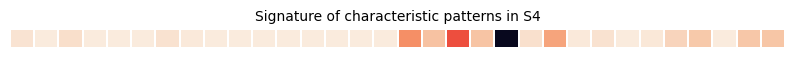

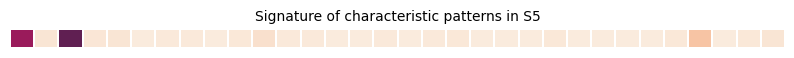

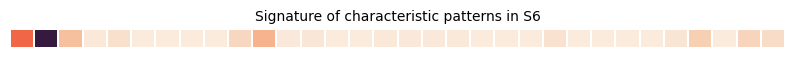

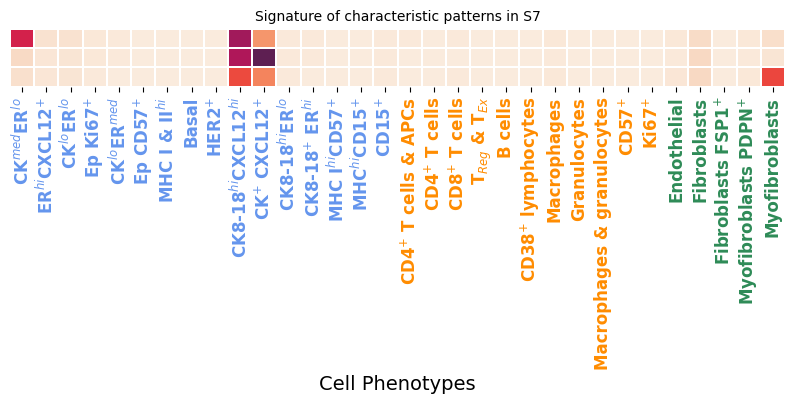

In [27]:
for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    if len(characteristic_patterns) ==0:
        continue
    f, ax= plt.subplots(1,1,figsize=(10,0.25*len(characteristic_patterns)))
    sns.heatmap(
            Signatures[np.array(characteristic_patterns), :],
            ax=ax,
            cbar=False,
            cmap="rocket_r",
            linewidth=0.005,
            vmax=np.percentile(Signatures, 99),
            vmin=np.percentile(Signatures, 1),

        )
    ax.get_yaxis().set_visible(False)
    if subgroup_id == 'S7':
        ax.set_xticklabels(
            Cell_types_displayed_Danenberg, rotation=90, fontsize=12, fontweight="bold"
        )
        ax.set_xlabel("Cell Phenotypes", fontsize=14)
        xtickcolors = ["cornflowerblue"] * 16 + ["darkorange"] * 11 + ["seagreen"] * 5
        for xtick, color in zip(ax.get_xticklabels(), xtickcolors):
            xtick.set_color(color)
    else:
        ax.get_xaxis().set_visible(False)
    ax.set_title(f"Signature of characteristic patterns in {subgroup_id}", fontsize=10)
    plt.show()



### Fig.10 Representative examples of characteristic patterns in each patient subgroup. 

In [11]:
explainer_ = Explainer()
X_prime = bigraph_.fitted_soft_wl_subtree.X_prime
Signatures = bigraph_.fitted_soft_wl_subtree.Signatures

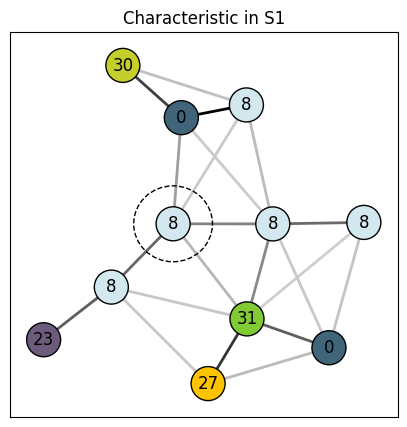

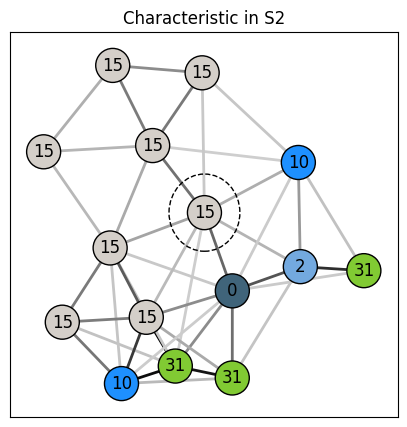

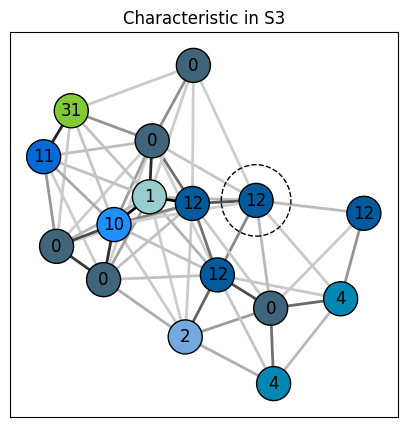

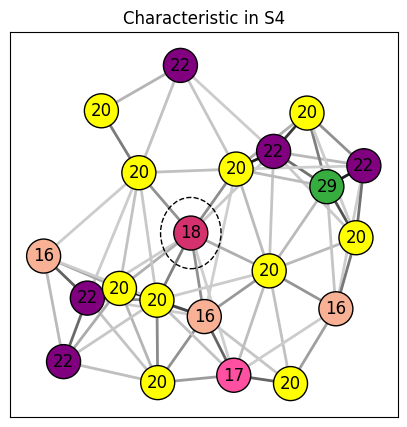

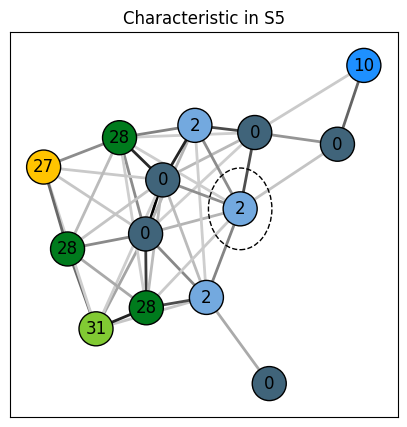

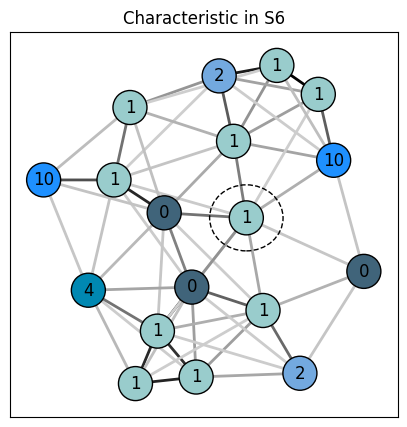

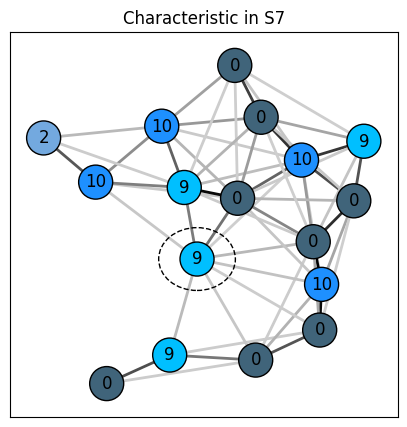

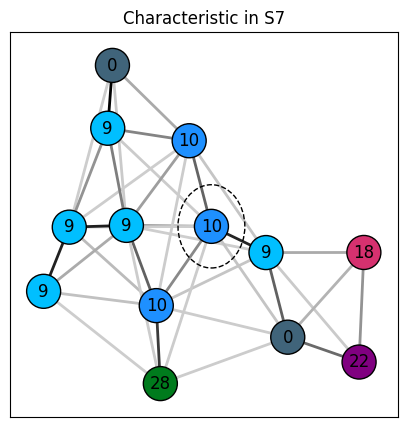

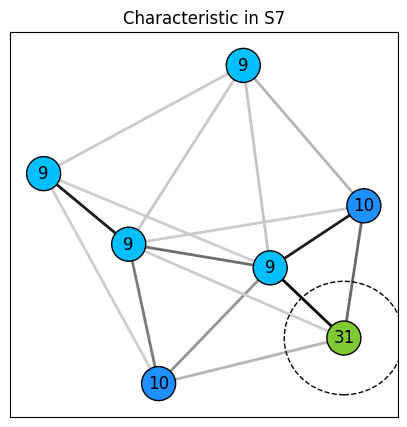

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


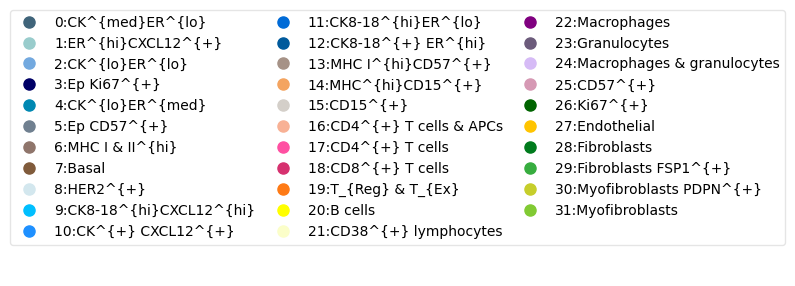

In [15]:
def get_pos(G):
    x = nx.get_node_attributes(G, "coorX")
    y = nx.get_node_attributes(G, "coorY")
    pos = {}
    for key, _ in x.items():
        pos[key] = (x[key], y[key])
    return pos


def normalize_pos(pos):
    x = np.array([pos[key][0] for key in pos.keys()])
    y = np.array([pos[key][1] for key in pos.keys()])
    x = x - np.mean(x)
    y = y - np.mean(y)
    pos_normalized = {}
    for i, key in enumerate(pos.keys()):
        pos_normalized[key] = (x[i], y[i])
    return pos_normalized


def decide_subtree_boundary(root_idx, Adj, iteration, boundary_weight_threshold=0.1):
    W = Adj.copy()
    for i in range(iteration):
        W = np.matmul(W, Adj)
    leaf_indices = list(np.where(W[root_idx, :] > boundary_weight_threshold)[0])
    return leaf_indices


for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    for pattern_index in range(len(characteristic_patterns)):
        pattern_id = characteristic_patterns[pattern_index]
        representative_subtrees = explainer_.find_representative_subtrees(
            X_prime, Signatures, pattern_id, n=1
        )
        for patient_id, subtree_root_local_idx in representative_subtrees:
            adj = X_prime[patient_ids_discovery.index(patient_id)][1]
            subtree_leaves_local_idx = decide_subtree_boundary(
                subtree_root_local_idx, adj, 2, boundary_weight_threshold=0.1
            )
            cells_ = cells_discovery.loc[
                cells_discovery.patientID == patient_id
            ].reset_index(drop=True)
            adj_ = adj.copy()
            adj_[adj_ < 0.01] = 0
            np.fill_diagonal(adj_, 0)
            cellular_graph = nx.from_numpy_array(adj_)
            nx.set_node_attributes(cellular_graph, cells_["coorX"], "coorX")
            nx.set_node_attributes(cellular_graph, cells_["coorY"], "coorY")
            nx.set_node_attributes(cellular_graph, cells_["celltypeID"], "celltypeID")
            nx.set_node_attributes(cellular_graph, cells_["meta_description"], "meta_description")
            subtree_graph = nx.subgraph(cellular_graph, subtree_leaves_local_idx)
            edge_list = list(subtree_graph.edges())
            edge_alpha = [
                (
                    10 * subtree_graph[u][v]["weight"]
                    if subtree_graph[u][v]["weight"] > 0.01
                    else 0
                )
                for u, v in edge_list
            ]
            edge_alpha = np.array(edge_alpha)
            cmap_greys = plt.get_cmap("Greys")
            start_point = 0.3
            end_point = 1.0
            new_cmap_colors = cmap_greys(np.linspace(start_point, end_point, 256))
            new_cmap = mcolors.LinearSegmentedColormap.from_list(
                "Greys_RightHalf", new_cmap_colors
            )
            f, ax = plt.subplots(figsize=(5, 5))
            circle = plt.Circle(
                (
                    normalize_pos(get_pos(subtree_graph))[subtree_root_local_idx][0],
                    normalize_pos(get_pos(subtree_graph))[subtree_root_local_idx][1],
                ),
                5,
                color="k",
                fill=False,
                linestyle="--",
            )
            nx.draw_networkx(
                subtree_graph,
                normalize_pos(get_pos(subtree_graph)),
                node_size=600,
                node_color=[
                    get_node_color("Danenberg", "CellType")[cell_type]
                    for cell_type in list(
                        nx.get_node_attributes(subtree_graph, "meta_description").values()
                    )
                ],
                labels=nx.get_node_attributes(subtree_graph, "celltypeID"),
                font_color="k",
                with_labels=True,
                edgecolors="k",
                ax=ax,
                edge_color=edge_alpha,
                edge_cmap=new_cmap,
                width=2,
            )
            ax.add_patch(circle)
            ax.set_title("Characteristic in {}".format(subgroup_id), fontsize=12)
fig, ax = plt.subplots(figsize=(10, 0.4), tight_layout=True)
func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
cell_types = [
    str(i) + ":" + reverse_dict(get_node_id("Danenberg", "CellType"))[i]
    for i in range(len(get_node_id("Danenberg", "CellType")))
]
handles = [
    func("o", get_node_color("Danenberg", "CellType")[i.split(":")[1]])
    for i in cell_types
]
ax.legend(
    handles,
    cell_types,
    loc=3,
    framealpha=0.5,
    frameon=1,
    ncols=3,
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    mode="expand",
    borderaxespad=0.0,
    fontsize=10,
)

ax.axis("off")
plt.show()

## Test Prognostic imapcts of characteristic patterns

### Fig. 11 Prognostic impacts of the characteristic TME patterns.

In [26]:
Histograms = bigraph_.fitted_soft_wl_subtree.Histograms
Proportions = Histograms/np.sum(Histograms, axis=1, keepdims=True)

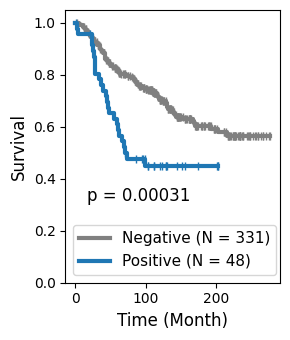

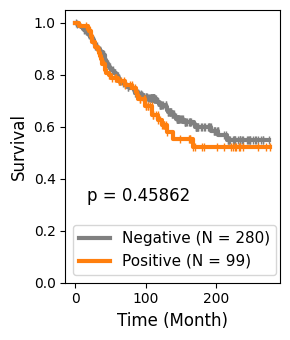

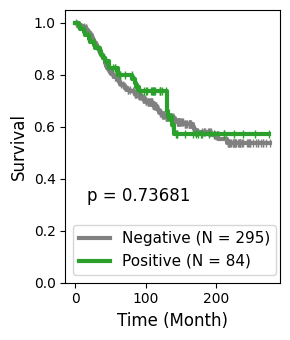

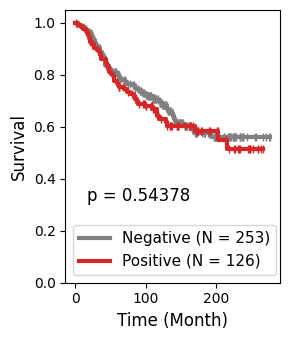

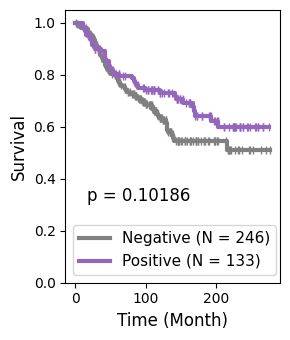

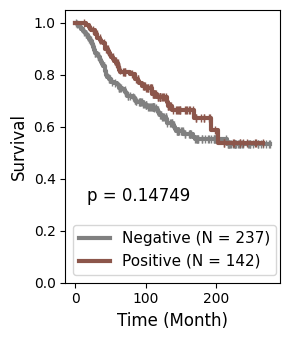

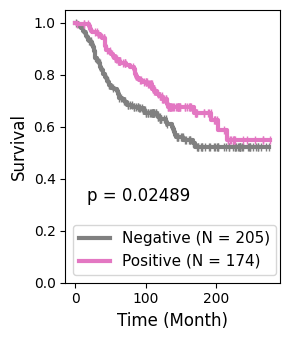

In [30]:
threshold = 0.01
for i in range(len(patient_subgroups_discovery)):
    subgroup_id = patient_subgroups_discovery[i]["subgroup_id"]
    characteristic_patterns = patient_subgroups_discovery[i]["characteristic_patterns"]
    f, ax = plt.subplots(figsize=(3, 3.5), tight_layout=True)
    proportion = Proportions[:, np.array(characteristic_patterns)].sum(axis=1) 
    kmf = KaplanMeierFitter()
    kmf.fit(
        np.array(lengths_discovery)[proportion < threshold],
        np.array(statuses_discovery)[proportion < threshold],
        label="Negative (N = {})".format(np.sum(proportion < threshold)),
    )
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 6, "marker": "|"},
        color="grey",
        linewidth=3,
    )
    kmf.fit(
        np.array(lengths_discovery)[(proportion >= threshold)],
        np.array(statuses_discovery)[(proportion >= threshold)],
        label="Positive (N = {})".format(np.sum((proportion >= threshold))),
    )
    kmf.plot_survival_function(
        ax=ax,
        ci_show=False,
        show_censors=True,
        censor_styles={"ms": 6, "marker": "|"},
        color=color_palette_Bigraph[subgroup_id],
        linewidth=3,
    )
    test = logrank_test(
        np.array(lengths_discovery)[proportion <= threshold],
        np.array(lengths_discovery)[(proportion > threshold)],
        np.array(statuses_discovery)[proportion <= threshold],
        np.array(statuses_discovery)[(proportion > threshold)],
    )
    ax.text(
        0.1, 0.3, "p = {:.5f}".format(test.p_value), fontsize=12, transform=ax.transAxes
    )
    ax.set(ylim=[0, 1.05], xlabel="Time (Month)", ylabel="Survival")
    ax.set_xlabel("Time (Month)", fontsize=12)
    ax.set_ylabel("Survival", fontsize=12)
    ax.legend(fontsize=11)
    plt.show()

# 5.Validation and Generalization